# code in progress. see demo.ipynb for working version 

In [58]:
## Imports

# Native packages
from math import radians, degrees, sin, cos, asin, acos, sqrt
import datetime
import sys


# Third-party packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Third-party packages for data interpolation
from scipy import interpolate
from scipy.interpolate import griddata
from xgcm import Grid

# Third-party packages for data visualizations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

# osse tools package
# del sys.modules['osse_tools']  # uncomment if troubleshooting osse_tools
from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp

In [59]:
# --------------------------------------------------------------------
# USER INPUTS:
# --------------------------------------------------------------------

# specify region from this list:
# WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST
# MarmaraSea  LabradorSea  CapeBasin
RegionName = 'ACC_SMST' 

# specify date range as start date & number of days.
start_date = datetime.date(2012,1,1)
ndays = 31
# ndays = 2
ndays = 10

# directory where data files are stored
# datadir = './data/' # default is ./data
datadir = '/data1/adac/mitgcm/netcdf/' + RegionName +'/'

# optional details for sampling (if not specified, reasonable defaults will be used)
# ** not implemented **
sampling_details = {
    'SAMPLING_STRATEGY' : 'sim_mooring', # options: sim_glider, sim_uctd or trajectory_file.add: mooring, ASV
    'PATTERN' : 'lawnmower', # back-forth or lawnmower 
    'zrange' : [-1, -1000],  # depth range of T/S profiles (down is negative). * add U/V range? *
    'hspeed' : 0.25,  # platform horizontal speed in m/s
    'vspeed' : 0.1, # platform vertical (profile) speed in m/s 
    'trajectory_file' : None, # if SAMPLING_STRATEGY = 'trajectory_file', specify trajectory file
    'AT_END' : 'repeat' # behaviour at and of trajectory: 'reverse', 'repeat' or 'terminate'. (could also 'restart'?)
}


# --------------------------------------------------------------------

#### Download & load model data and derived fields

Based on [LLC4320](https://data.nas.nasa.gov/viz/vizdata/llc4320/index.html), the 1/48-degree global MITgcm simulation produced by the ECCO project. Ten regional cut-outs of the simulation are available on the [PO.DAAC](https://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=); the 4x4 degree regional domains are small enough to enable fairly easy downloads and processing. The data from the model were retrieved using download_llc4320.ipynb and saved locally.

In [60]:
# download files:
# download_llc4320_data(RegionName, datadir, start_date, ndays)
del sys.modules['osse_tools']  # uncomment if troubleshooting osse_tools
from osse_tools import  compute_derived_fields

# derive & save new files with steric height & vorticity
# compute_derived_fields(RegionName, datadir, start_date, ndays)
compute_derived_fields(RegionName, datadir, start_date, ndays)

In [61]:
# Load all model data files  
date_list = [start_date + datetime.timedelta(days=x) for x in range(ndays)]
target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
ds = xr.open_mfdataset(target_files, parallel=True)

# load the corresponding derived fields
derivedir = datadir + 'derived/'
derived_files = [f'{derivedir}LLC4320_pre-SWOT_{RegionName}_derived-fields_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
dsd = xr.open_mfdataset(derived_files)

# merge the derived and raw data
ds = ds.merge(dsd)

# Change time from datetime to integer
ds = ds.assign_coords(time=np.linspace(0,ds.time.size-1, num=ds.time.size)) # time is now in hours

# Convert lon, lat and z to index i, j and k with f_x, f_y and f_z
# XC, YC and Z are the same at all times, so select a single time
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)

### Create & plot sampling track

In [62]:
del sys.modules['osse_tools'] 
from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp
# sampling_details['SAMPLING_STRATEGY']='sim_glider'
# sampling_details['SAMPLING_STRATEGY']='sim_mooring'
# *** can't change sampling_details here :(
# sampling_details['zmooring_TS'] = [-0.5]
# sampling_details['xmooring'] = [ds.XC.sel(i=0,j=0,time=0).values]
# sampling_details['ymooring'] = [ds.YC.sel(i=0,j=0,time=0).values]

# sampling_details = {
#     'SAMPLING_STRATEGY' : 'sim_uctd', # options: sim_glider, sim_uctd or trajectory_file.add: mooring, ASV
#     'PATTERN' : 'lawnmower', # back-forth or lawnmower 
#     'AT_END' : 'repeat' # behaviour at and of trajectory: 'reverse', 'repeat' or 'terminate'. (could also 'restart'?)
# }
survey_track, survey_indices, sampling_parameters = get_survey_track(ds, sampling_details)


In [184]:
sampling_details = {
    'SAMPLING_STRATEGY' : 'sim_mooring', # options: sim_glider, sim_uctd or trajectory_file.add: mooring, ASV
    'PATTERN' : 'lawnmower', # back-forth or lawnmower 
    'zrange' : [-1, -1000],  # depth range of T/S profiles (down is negative). * add U/V range? *
    'hspeed' : 0.25,  # platform horizontal speed in m/s
    'vspeed' : 0.1, # platform vertical (profile) speed in m/s 
    'trajectory_file' : None, # if SAMPLING_STRATEGY = 'trajectory_file', specify trajectory file
    'AT_END' : 'repeat' # behaviour at and of trajectory: 'reverse', 'repeat' or 'terminate'. (could also 'restart'?)
}


list_of_sampling_details = ['zrange','hspeed','vspeed','AT_END','xmooring','ymooring',
                        'zmooring_TS','zmooring_UV','dzmooring_TS','dzmooring_UV'];
sampling_details
for sd in list_of_sampling_details:
    if sd in sampling_details:
        print(1)
    else:
        print(0)
#         exec([sampling_details[sd] + ' = "sd"'])
        print([sampling_details[sd] + ' = "sd"'])
    
sampling_details
# *** NOT WORKING - can't just pass exec variables :( ***
# obvi this isn't the right way to rename variables ... 
# probably should just call the dict later
#     for sd in list_of_sampling_details:
#         if sd in sampling_details and sampling_details[sd] is not None:
#             exec(sd + ' = sampling_details["' + sd + '"]',None, globals())
#             exec(sd + ' = sampling_details["' + sd + '"]')
#             print('a = sampling_details["' + sd + '"]')
#             exec('a = 3',None, globals() )
#     print(sampling_details["zmooring_TS"])
#     zmooring_TS = sampling_details["zmooring_TS"]
#     print(zmooring_TS)
#     print(a)

1
1
1
1
0


KeyError: 'xmooring'

In [275]:
sampling_details.items()
# sampling_details.values()

dum = {
    't1':2}
dum.items()
sd = 'PATTERN'
exec('dum["test"]=1')
newvar = 'xxx'
exec('dum[newvar]=1')
newvar2 = 'yyy'
exec('dum[newvar] = "' + '999"')
newvar2 = 'ttt'
exec('dum[newvar] = "' + sd + '"')



exec('dum[sd] = "' + sd + '"')
# exec('"' + sd + '" = dum[sd]')
exec(sd + ' = sampling_details[sd]')
# exec('dum[sd] = "' + sd + '"')
# sd
PATTERN

# exec('sd = ' + dum[sd] + '')
# print(dum)



# print(sampling_details['PATTERN'])
# exec('sd = ' + "'" + sampling_details[PATTERN] + "'")
# 
# dum.items()
# for sd in sampling_details.keys():
#     print(sd)
#     print(sampling_details[sd])
    
#         exec(sd + ' = "' + sampling_details[sd] + '"')

'lawnmower'

In [255]:
defaults = {
    'zrange': [-5, -500], # depth range of profiles (down is negative)
    'hspeed': 5, # platform horizontal speed in m/s
    'vspeed': 1 # platform vertical (profile) speed in m/s (NOTE: may want different up/down speeds)  
}
print(sampling_details)
print(defaults)
dd = {**defaults, **sampling_details}
print(dd)

{'SAMPLING_STRATEGY': 'sim_mooring', 'PATTERN': 'lawnmower', 'zrange': [-1, -1000], 'hspeed': 0.25, 'vspeed': 0.1, 'trajectory_file': None, 'AT_END': 'repeat'}
{'zrange': [-5, -500], 'hspeed': 5, 'vspeed': 1}
{'zrange': [-1, -1000], 'hspeed': 0.25, 'vspeed': 0.1, 'SAMPLING_STRATEGY': 'sim_mooring', 'PATTERN': 'lawnmower', 'trajectory_file': None, 'AT_END': 'repeat'}


In [226]:
dum = 10
sss = 's'
exec('dum = "' + sss + '"')
dum


's'

In [257]:
sampling_details.values()

dict_values(['sim_mooring', 'lawnmower', [-1, -1000], 0.25, 0.1, None, 'repeat'])

### Visualizations

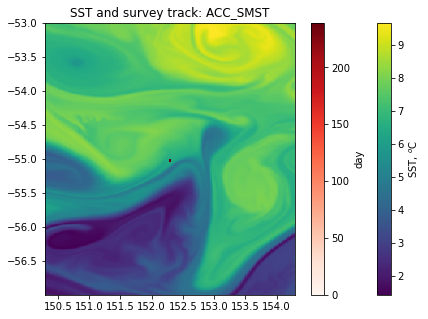

In [6]:
## Visualize track over a single model snapshot:
%matplotlib inline
plt.figure(figsize=(7,5))
ssto = plt.pcolormesh(X,Y,ds.Theta.isel(k=0, time=0).values, shading='auto')
tracko = plt.scatter(survey_track.lon, survey_track.lat, c=survey_track.time, cmap='Reds', s=0.75)
plt.title('SST and survey track: ' + RegionName)
plt.colorbar(ssto).set_label('SST, $^o$C')
plt.colorbar(tracko).set_label('day')
plt.show()

### Interpolate data with the specified sampling pattern (this is where the magic happens!)

In [169]:
del sys.modules['osse_tools'] 
from osse_tools import survey_interp, get_survey_track
survey_track, survey_indices, sampling_parameters = get_survey_track(ds, sampling_details)
sdata, sgr = survey_interp(ds, survey_track, survey_indices)

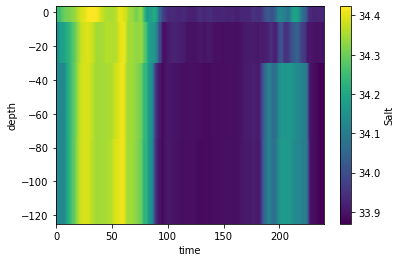

In [168]:
sgr.Salt.plot()

In [153]:
## troubleshoot
# - don't need to copy this part back over
subsampled_data = sdata.copy()
vbls3d = ['Theta','Salt','vorticity','steric_height']
SAMPLING_STRATEGY = sampling_details['SAMPLING_STRATEGY']


In [154]:
## troubleshoot
# get times associated with profiles:
# - for mooring, use the subsampled time grid:
if SAMPLING_STRATEGY == 'sim_mooring':
    times = np.unique(subsampled_data.time.values)
else:
    # -- take the shallowest & deepest profiles (every second value, since top/bottom get sampled twice for each profile)
    time_deepest = subsampled_data.time.where(subsampled_data.dep == subsampled_data.dep.min(), drop=True).values[0:-1:2]
    time_shallowest = subsampled_data.time.where(subsampled_data.dep == subsampled_data.dep.max(), drop=True).values[0:-1:2]
    times = np.sort(np.concatenate((time_shallowest, time_deepest)))
    # this results in a time grid that may not be uniformly spaced, but is correct
    # - for a uniform grid, use the mean time spacing - may not be perfectly accurate, but is evenly spaced
    dt = np.mean(np.diff(time_shallowest))/2 # average spacing of profiles (half of one up/down, so divide by two)
    times_uniform = np.arange(survey_track.n_profiles.values*2) * dt
# nt is the number of profiles (times):
nt = len(times)  
# xgr is the vertical grid; nz is the number of depths for each profile
zgridded = np.unique(subsampled_data.dep.data)
nz = int(len(zgridded))

# -- initialize the dataset:
sgridded = xr.Dataset(
    coords = dict(depth=(["depth"],zgridded),
              time=(["time"],times))
)
# -- 3-d fields: loop & reshape 3-d data from profiles to a 2-d (depth-time) grid:
# first, extract each variable, then reshape to a grid
for vbl in vbls3d:
    this_var = subsampled_data[vbl].data.compute().copy() 
    # reshape to nz,nt
    this_var_reshape = np.reshape(this_var,(nz,nt), order='F') # fortran order is important!
    # for platforms with up & down profiles (uCTD and glider),
    # every second column is upside-down (upcast data)
    # starting with the first column, flip the data upside down so that upcasts go from top to bottom
    if SAMPLING_STRATEGY != 'sim_mooring':
        this_var_fix = this_var_reshape.copy()
        this_var_fix[:,0::2] = this_var_fix[-1::-1,0::2] 
        sgridded[vbl] = (("depth","time"), this_var_fix)
    elif SAMPLING_STRATEGY == 'sim_mooring':
        sgridded[vbl] = (("depth","time"), this_var_reshape)
# for sampled steric height, we want the value integrated from the deepest sampling depth:
sgridded['steric_height'] = (("time"), sgridded['steric_height'].isel(depth=nz-1))
# rename to "sampled" for clarity
sgridded.rename_vars({'steric_height':'steric_height_sampled'})

#  -- 2-d fields: loop & reshape 2-d data to the same time grid 
vbls2d = ['steric_height_true', 'Eta', 'KPPhbl', 'PhiBot', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux']
for vbl in vbls2d:
    this_var = subsampled_data[vbl].data.compute().copy() 
    # subsample to nt
    this_var_sub = this_var[0:-1:nz]
    sgridded[vbl] = (("time"), this_var_sub)


<xarray.Dataset>
Dimensions:             (i: 192, i_g: 192, j: 349, j_g: 349, k: 84, k_l: 84, k_p1: 85, k_u: 84, nb: 2, time: 240, zref: 27)
Coordinates: (12/13)
  * i                   (i) float64 0.0 1.0 2.0 3.0 ... 188.0 189.0 190.0 191.0
  * j                   (j) float64 0.0 1.0 2.0 3.0 ... 345.0 346.0 347.0 348.0
  * j_g                 (j_g) float32 0.0 1.0 2.0 3.0 ... 346.0 347.0 348.0
  * i_g                 (i_g) float32 0.0 1.0 2.0 3.0 ... 189.0 190.0 191.0
  * k                   (k) int32 0 1 2 3 4 5 6 7 8 ... 76 77 78 79 80 81 82 83
  * k_u                 (k_u) int32 0 1 2 3 4 5 6 7 ... 76 77 78 79 80 81 82 83
    ...                  ...
  * k_p1                (k_p1) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
  * nb                  (nb) int32 0 1
  * time                (time) float64 0.0 1.0 2.0 3.0 ... 237.0 238.0 239.0
    xav                 float32 151.5
    yav                 float32 -55.5
  * zref                (zref) float32 0.0 5.0 10.0 ... 1.5e+03 1.75e+03 2e+03
Data variables: (12/40)
    XC                  (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    YC                  (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    DXV                 (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    DYU                 (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    Depth               (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    AngleSN             (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    ...                  ...
    W                   (time, k_l, j, i) float64 dask.array<chunksize=(24, 84, 349, 192), meta=np.ndarray>
    vorticity           (time, k, j, i) float32 dask.array<chunksize=(24, 84, 349, 192), meta=np.ndarray>
    steric_height       (time, k, j, i) float32 dask.array<chunksize=(24, 84, 349, 192), meta=np.ndarray>
    steric_height_true  (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    Tref                (time, zref) float32 dask.array<chunksize=(24, 27), meta=np.ndarray>
    Sref                (time, zref) float32 dask.array<chunksize=(24, 27), meta=np.ndarray>
Attributes: (12/56)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Dimitris Menemenlis et al.
    contributor:                     Chris Hill, Christopher E. Henze, Jinbo ...
    contributor_role:                MITgcm developer, AMES supercomputer sup...
    cdm_data_type:                   Grid
    Conventions:                     CF-1.7, ACDD-1.3
    ...                              ...
    time_coverage_end:               2012-01-01 23:00:00
    time_coverage_start:             2012-01-01 00:00:00
    title:                           LLC4320 regional Southern Ocean
    geospatial_lon_resolution:       variable
    geospatial_lat_resolution:       variable
    platform:                        MITgcm

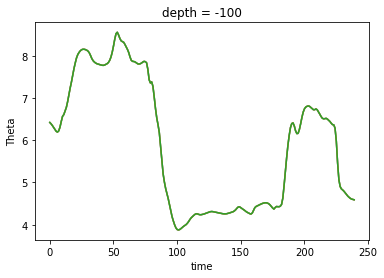

In [143]:
# for mooring, can we just interpolate the gridded fields directly rather than interpolating to points and then re-gridding?
# YES but it's slower (!?!)
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)
i = ds.i
j = ds.j
z = ds.Z.isel(time=0)
k = ds.k
f_x = interpolate.interp1d(X[0,:].values, i)
f_y = interpolate.interp1d(Y[:,0].values, j)
f_z = interpolate.interp1d(z, k, bounds_error=False)

#
model_xav = ds.XC.isel(time=0, j=0).mean(dim='i').values
model_yav = ds.YC.isel(time=0, i=0).mean(dim='j').values
xmooring = model_xav # default lat/lon is the center of the domain
ymooring = model_yav
zmooring_TS = [-1, -10, -50, -100] # depth of T/S instruments
zmooring_UV = [-1, -10, -50, -100] # depth of U/V instruments

#
# ds.Theta.sel(k=1)
# ds.Theta.sel(k=1)
ki = f_z(zmooring_TS[0])
ii = f_x(xmooring)
ji = f_y(ymooring)
xo = ds.interp(i=ii, j=ji, k=ki)
xo.Theta.plot.line(x='time')
sdata.Theta.where(sdata.dep == sdata.dep.max(), drop=True).plot.line(x='time')
sgridded.Theta.isel(depth=0).plot()

In [88]:
960/4

240.0

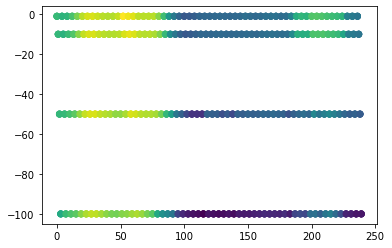

In [8]:
# sdata.Theta.plot(x='time', y='dep', c='Theta')
plt.scatter(x=sdata.time.data, y=sdata.dep.data, c=sdata.Theta.data)
#plt.scatter(sdata.time,sdata.dep, c=sdata.Salt)

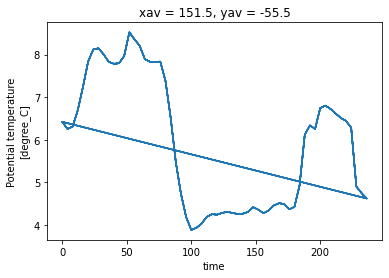

In [19]:
sdata.Theta.where(sdata.dep == sdata.dep.max(), drop=True).plot.line(x='time')

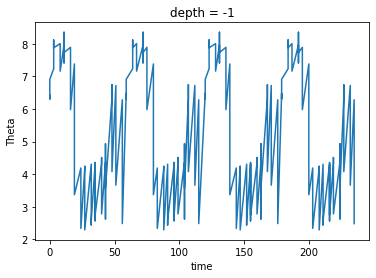

In [24]:
# plt.scatter(x=sgr.time.data, y=sgr.depth.data, c=sgr.Theta.data)
sgr.Theta.isel(depth=3).plot.line(x='time')

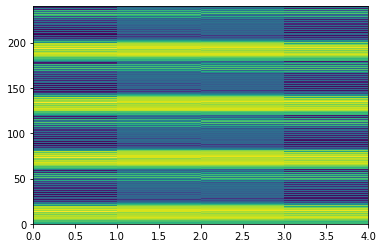

In [27]:
plt.pcolormesh(np.transpose(sgr.Theta.data))

In [ ]:
subsampled_deepest = sdata.where(sdata.dep == sdata.dep.min(), drop=True)
subsampled_deepest.steric_height.plot()
# sdata['steric_height_sampled']=subsampled_deepest
sdata

In [ ]:
plt.plot(sdata.steric_height,'.')
plt.plot(sdata.steric_height_true,'.')
subsampled_deepest.steric_height.plot()

### Regrid the data to depth/time
by first extracting each variable from dataarray => np array\
then reshaping to a grid,\
then flipping every second column 

In [ ]:
# get times associated with profiles:
# - take the shallowest & deepest profiles (every second value, since top/bottom get sampled twice for each profile)
time_deepest = sdata.time.where(sdata.dep == sdata.dep.min(), drop=True).values[0:-1:2]
time_shallowest = sdata.time.where(sdata.dep == sdata.dep.max(), drop=True).values[0:-1:2]
times = np.sort(np.concatenate((time_shallowest, time_deepest)))
# this results in a time grid that may not be uniformly spaced, but is correct
# - for a uniform grid, use the mean time spacing - may not be perfectly accurate, but is evenly spaced
dt = np.mean(np.diff(time_shallowest))/2 # average spacing of profiles (half of one up/down, so divide by two)
times_uniform = np.arange(survey_track.n_profiles.values*2) * dt
# nt is the number of profiles (times):
nt = len(times)  # number of profiles
# xgr is the vertical grid; nz is the number of depths for each profile
zgridded = np.unique(sdata.dep.data)
nz = int(len(zgridded))

# initialize the dataset:
sgridded = xr.Dataset(
    coords = dict(depth=(["depth"],zgridded),
                  time=(["time"],times))
)


# loop & reshape 3-d data from profiles to a 2-d (depth-time) grid:
for vbl in vbls3d:
    this_var = sdata[vbl].data.compute().copy() 
    # reshape to nz,nt
    this_var_reshape = np.reshape(this_var,(nz,nt), order='F') # fortran order is important!
    # every second column (starting with the first column): 
    # flip the data upside down so that upcasts go from top to bottom
    this_var_fix = this_var_reshape.copy()
    this_var_fix[:,0::2] = this_var_fix[-1::-1,0::2] 
    sgridded[vbl] = (("depth","time"), this_var_fix)
    

# for sampled steric height, we want the value integrated from the deepest sampling depth:
sgridded['steric_height'] = (("time"), sgridded['steric_height'].isel(depth=len(zgr)-1))
# rename to "sampled" for clarity
sgridded.rename_vars({'steric_height':'steric_height_sampled'})

for vbl in vbls2d:
    this_var = sdata[vbl].data.compute().copy() 
    # subsample to nt
    this_var_sub = this_var[0:-1:nz]
    sgridded[vbl] = (("time"), this_var_sub)


In [ ]:
sgridded.Theta.plot(x='time', y='depth')

In [ ]:
sgridded = xr.Dataset(
    coords = dict(depth=(["depth"],zgridded),
                  time=(["time"],times))
)
sgridded

In [ ]:
# loop & reshape 2-d data to the same grid 
vbls2d = ['steric_height_true', 'Eta', 'KPPhbl', 'PhiBot', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux']
for vbl in vbls2d:
    this_var = sdata[vbl].data.compute().copy() 
    # subsample to nt
    this_var_sub = this_var[0:-1:nz]
    sgridded[vbl] = (("time"), this_var_sub)
sgridded

In [ ]:
sgridded.steric_height.isel(depth=494).plot()
sgridded.steric_height_true.plot()

In [ ]:
vbl = 'Eta'
this_var = sdata['Eta'].data.compute().copy()
this_var.shape
# subsample nt
print(nt)
this_var_sub = this_var[0:-1:nz]
print(this_var_sub.shape)
# plt.plot(this_var,'.')
plt.plot(this_var_sub,'.')

sgridded[vbl] = (("time"), this_var_sub)
sgridded.Eta.plot()
sgridded.steric_height.isel(depth=494).plot()
sgridded

In [ ]:
sgridded.steric_height.isel(depth=[0]).plot()
sgridded.steric_height.isel(depth=[494]).plot()

In [ ]:
# regrid the data in a clunky way, by first extracting each variable from dataarray => np array
# then reshaping to a grid,
# then flipping every second column 

# - for troubleshooting - do dep:
# vbl = 'dep'
# this_var = sdata[vbl].data.copy() 

vbl = 'Theta'
this_var = sdata[vbl].data.compute().copy() 

# need to figure out the actual times associated with profiles!
tgr = np.arange(survey_track.n_profiles.values)
nt = len(tgr)*2 # *** the *2 accounts for the fact that z are down/up, so there are actually twice as many profiles!!! 
# nz is the number of depths
zgr = np.unique(sdata.dep.data)
nz = int(len(zgr))
# nz = int(len(sdata.dep)/nt) # also works

# reshape
this_var_reshape = np.reshape(this_var,(nz,nt), order='F') # fortran order is important!
this_var_fix = this_var_reshape.copy()
# * every second column: flip the data upside down so that upcasts go from top to bottom
this_var_fix[:,1::2] = this_var_fix[-1::-1,1::2] 


# scattered
ax = plt.subplot(311)
plt.scatter(sdata.time.data,sdata.dep.data,c=this_var)
# plt.xlim([0, 0.2])

# gridded - bad
ax = plt.subplot(312)
plt.pcolor(this_var_reshape)
# xl=[0,10]
# plt.xlim(xl)

# fixed
ax = plt.subplot(313)
plt.pcolor(this_var_fix)
# plt.xlim(xl)
plt.gca().invert_yaxis()
plt.show()
# looks good! 

In [ ]:
# test if the above regridding is correct by plotting the data at one level as a time series
# YES.

# shallowest (max because negative)
zpl = np.max(sdata['dep'].data)
print(zpl)

# select data at one depth:
this_var_onedep = sdata[vbl].where(sdata.dep == zpl, drop=True)

# fixed data at the same depth
this_var_fixed_onedep = this_var_fix[0,:]


# # deepest
# zpl = np.min(sdata['dep'].data)
# this_var_onedep = sdata[vbl].where(sdata.dep == zpl, drop=True)
# this_var_reshaped_onedep = this_var_reshape[494,:]
# print(zpl)


tpl = np.linspace(0,np.max(sdata['time']),len(this_var_reshaped_onedep))


plt.plot(sdata['time'].where(sdata.dep == zpl, drop=True).data, this_var_onedep.data,'.')
plt.plot(tpl,this_var_fixed_onedep,'r-.')

plt.show()

In [ ]:
# THIS DOESN'T QUITE WORK :(
# or maybe it does now?


# regrid the data, going from points to time x depth coordinates
# time from the shallowest part of the profile (?)
subsampled_data = sdata
# t_regrid = subsampled_data['time'].where(subsampled_data.dep == subsampled_data.dep.max(), drop=True).isel(points=slice(0,-1,2))
t_regrid = np.arange(survey_track.n_profiles.data) # time dimension - to start just make it the # of profiles
# depth is the unique depths
z_regrid = np.unique(subsampled_data['dep'])
# or ... so the numbers work out..
z_regrid = np.arange(len(sdata.points.data)/survey_track.n_profiles.data) # ??? should this be half as many?


multiindex_ds = sdata.assign_coords(
    tgrid=t_regrid, zgrid=z_regrid).stack(aux_dim=("tgrid", "zgrid")).rename(points="aux_dim").unstack("aux_dim")


ax = plt.subplot(311)
p=plt.scatter(sdata['time'].data,sdata['dep'].data,c=sdata['Theta'].data)
plt.colorbar(p)

ax = plt.subplot(312)

# if we only plot the top half of the regridded data.... looks great!
# multiindex_ds.Theta.plot()
# plt.pcolor(np.transpose(multiindex_ds.Theta.data))
# p = plt.pcolor(np.transpose(multiindex_ds.Theta.data[0:-1:2,0:-1:2]))
p = plt.pcolor(t_regrid, -z_regrid[0:494], np.transpose(multiindex_ds.Theta.data[:,0:494]))
plt.colorbar(p)
plt.show()

# plotting the whole thing- data is mirrored at bottom. we have to do the step where every second column is reversed
# - not sure how to do this in xarray
# but at least it works in normal np arrays!
ax = plt.subplot(313)
p = plt.pcolor(t_regrid, -z_regrid, np.transpose(multiindex_ds.Theta.data))
plt.colorbar(p)
plt.show()



### Visualize interpolated data in 3D

In [ ]:
%matplotlib qt

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
fig.subplots_adjust(left=0.25, bottom=0.25)

ax.set_xlabel('longitude', fontsize=15, rotation=150)
ax.set_ylabel('latitude',fontsize=15)
ax.set_zlabel('depth', fontsize=15, rotation=60)

p = ax.scatter3D(sdata.lon.data, sdata.lat.data, sdata.dep.data, c=sdata.Theta.data, s=1)
fig.colorbar(p).set_label('Temperature ($^o$C)')
ax.set_title('Temperature interpolated to the survey track')

In [ ]:
# THIS WORKS (but there's a copy vs view problem, so uncomment each plot one by one :/
i=np.arange(10000)
test=sdata['Theta'].data[i].compute()

ax = plt.subplot(411)
p=plt.scatter(sdata['time'].data[i],sdata['dep'].data[i],c=test)
plt.colorbar(p)

ax = plt.subplot(412)
treshape = np.transpose(np.reshape(test,(100,-1)))
p = plt.pcolor(treshape)
plt.colorbar(p)


ax = plt.subplot(413)
treshape_fix = treshape
treshape_fix[:,1::2] = treshape_fix[-1::-1,1::2]
p = plt.pcolor(treshape_fix)
plt.colorbar(p)


In [ ]:

# # treshape_half = treshape[:,slice(0,-1,2)]
# # treshape_otherhalf = treshape[slice(0,-1,2),:]
# # print(treshape)
# fig = plt.figure(figsize=(8, 4))                 
# ax = plt.subplot(411)
# p = ax.scatter(tm,zm,c=test, s=5)
# plt.colorbar(p)

# ax = plt.subplot(412)
# p = plt.pcolor(treshape)
# plt.colorbar(p)

# ax = plt.subplot(413)
# p=plt.pcolor(treshape_half)
# plt.colorbar(p)

# ax = plt.subplot(414)
# p=plt.pcolor(treshape_otherhalf)
# plt.colorbar(p)

# plt.show()

In [ ]:
# THIS WORKS for reversing every 2nd row. a/b must be arrays - if dash, use compute()
a = np.arange(20).reshape(4,5)
print(a)
b = a
b[:,1::2] = b[-1::-1,1::2]
print(b)

In [ ]:
multiindex_ds = sdata.assign_coords(
    t=np.arange(138), z=np.arange(988)
).stack(
    aux_dim=("t", "z")
).rename(points='aux_dim')


reshaped_ds = multiindex_ds.unstack("aux_dim")
reshaped_ds
# multiindex_ds = ds.assign_coords(
#     dim_0=["a", "b", "c"], dim_1=[0,1], dim_2=range(4)
# ).stack(
#     dim=("dim_0", "dim_1", "dim_2")
# ).reset_index(
#     "row", drop=True
# ).rename(
#     row="dim"
# )
# multiindex_ds


In [ ]:
plt.pcolor(reshaped_ds['Theta'].data)

In [ ]:
# reshaped_ds.sel(t=slice(0,len(t),2))['Theta'].plot()
plt.plot(reshaped_ds.sel(t=slice(0,len(t),2))['Theta'].data)

In [ ]:
a = np.random.rand(20).reshape(5,4) * [1,2,3,4]
print(a)
print(a[:,0::2])
print(a[-1::-1,0::2])
a[:,0::2] = a[-1::-1,0::2]
print(a)

In [ ]:
# "sdata" is on points- not that useful! interpolate to a regular#
# time/depth grid, which comes from the unique values of 
# all times/depths in sdata.
# using unique depth and times works for mooring
# but for glider or uctd there is a unique time for each datapoint, 
# so we probably want to interpolate in x/y instead ... ?
if sampling_details['SAMPLING_STRATEGY']='sim_glider'
    xgr = 
elif sampling_details['SAMPLING_STRATEGY']='sim_mooring'
    tgr = np.unique(sdata.time)
    zgr = np.unique(sdata.dep)
    (tm, zm) = np.meshgrid(tgr, zgr)

len(zgr)

In [ ]:
sdata

In [ ]:
dum = griddata((sdata.time.data, sdata.dep.data), sdata.Salt.data, (tm, zm), method='linear')
plt.plot(tgr,np.transpose(dum),'-')
print(1)

In [ ]:
# ALTERNATIVE METHOD to survey_interp:
# ?? interpolate to a set of i.j.k rather than interpolating to "points" and then reshaping/interpolating
# --> slower
dsi = xr.Dataset()
vbls3d = ['Theta','Salt','vorticity','steric_height']
for vbl in vbls3d:
    # lazy & fast
    dsi[vbl] = ds[vbl].interp(i=np.unique(sdata.i), j=np.unique(sdata.j), k=np.unique(sdata.k))


# actual computation, so it's the slow part 
sss = dsi.Salt.values

In [ ]:
# plot to compare the two methods 
# ( not quite working )
tpl = ds['time']/24,sss[:,0,0,0]
ttt=ds['time']
# ipl = ( sdata.dep.values == sdata.dep.values.min() )
# plt.plot(sdata.time(ipl),sdata.Salt.sel(ipl).data,'-')
# plt.plot(sdata.time,sdata.Salt.data,'-')
plt.plot(tgr,np.transpose(dum),'-')
plt.plot(ttt[:],sss[:,0,0,0],'k--')
# plt.legend('survey_interp method','direct interpolation')

### Visualize steric height

In [ ]:
%matplotlib inline
sh_anom = sh_true.values - sh_true.values.mean()
plt.figure(figsize=(7,5))
sho = plt.scatter(survey_track.lon, survey_track.lat, c=sh_anom)
plt.title('Steric height anomaly')
plt.colorbar(sho).set_label('m')
plt.show()

### Comparison of true vs sampled steric height
Plot comparing the "true" steric height along the track and the subsampled steric height, which is computed by integrating the specific volume anomaly for each subsampled profile from its deepest sampling depth

In [ ]:
%matplotlib inline

# truth:
plt.plot(sh_true.time, sh_true.values - sh_true.values.mean())
# get index of the deepest sampling depths
i = ( sdata.dep.values == sdata.dep.values.min() )
plt.plot(sdata.time.values[i], sdata.steric_height.values[i] - sdata.steric_height.values[i].mean(),'.-')
plt.title('Steric height anomaly along the survey track')
plt.legend(['truth','subsampled data'])
plt.xlabel('time, days')
plt.ylabel('steric height anom., m')

In [ ]:
# NEW CODE  BELOW

# interpolation:
subsampled_data = xr.Dataset()  

# loop & interpolate through 3d variables:
vbls3d = ['Theta','Salt','vorticity']
# vbls3d = ['Theta']
for vbl in vbls3d:
    subsampled_data[vbl]=ds[vbl].interp(survey_indices)
# # Interpolate U and V from i_g, j_g to i, j, then interpolate:
# U_c = grid.interp(ds.U, 'X', boundary='extend')
# V_c = grid.interp(ds.V, 'Y', boundary='extend')
# subsampled_data['U'] = U_c.interp(survey_indices)
# subsampled_data['V'] = V_c.interp(survey_indices)

subsampled_data['lon']=survey_track.lon
subsampled_data['lat']=survey_track.lat
subsampled_data['dep']=survey_track.dep
subsampled_data['time']=survey_track.time 

# loop & interpolate through 2d variables:
vbls2d = ['Eta', 'KPPhbl', 'PhiBot', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux', 'oceTAUX', 'oceTAUY']
vbls2d = ['Eta', 'Depth']
# create 2-d survey track by removing the depth dimension
survey_indices_2d =  survey_indices.drop_vars('k')
for vbl in vbls2d:
    subsampled_data[vbl]=ds[vbl].interp(survey_indices_2d)
# survey_indices_2d.i.plot()
# ds['KPPhbl'].interp(survey_indices_2d).plot()

# interp
# this returns a value at every timestep (points) - very high resolution
# - could subsample to the model time grid 


# plot
# plt.plot(sh_true.time, sh_true.values - sh_true.values.mean())
# plt.plot(subsampled_data.time, ssh - ssh.mean())


In [ ]:
subsampled_data = xr.Dataset() 

# loop & interpolate through 3d variables:
vbls3d = ['Theta','Salt','vorticity','steric_height']
for vbl in vbls3d:
    subsampled_data[vbl]=ds[vbl].interp(survey_indices)
# Interpolate U and V from i_g, j_g to i, j, then interpolate:
# Get u, v
grid = Grid(ds, coords={'X':{'center': 'i', 'left': 'i_g'}, 
                        'Y':{'center': 'j', 'left': 'j_g'},
                        'Z':{'center': 'k'}})
U_c = grid.interp(ds.U, 'X', boundary='extend')
V_c = grid.interp(ds.V, 'Y', boundary='extend')
subsampled_data['U'] = U_c.interp(survey_indices)
subsampled_data['V'] = V_c.interp(survey_indices)


# add lat/lon/time to dataset
subsampled_data['lon']=survey_track.lon
subsampled_data['lat']=survey_track.lat
subsampled_data['dep']=survey_track.dep
subsampled_data['time']=survey_track.time  

# loop & interpolate through 2d variables:
vbls2d = ['Eta', 'KPPhbl', 'PhiBot', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux']
# create 2-d survey track by removing the depth dimension
survey_indices_2d =  survey_indices.drop_vars('k')
for vbl in vbls2d:
    subsampled_data[vbl]=ds[vbl].interp(survey_indices_2d)   
# taux & tauy must be treated like U and V
oceTAUX_c = grid.interp(ds.oceTAUX, 'X', boundary='extend')
oceTAUY_c = grid.interp(ds.oceTAUY, 'Y', boundary='extend')
subsampled_data['oceTAUX'] = oceTAUX_c.interp(survey_indices_2d)
subsampled_data['oceTAUY'] = oceTAUY_c.interp(survey_indices_2d)


    

In [ ]:
ds.U

In [ ]:
plt.plot(sh_true.time, sh_true.values - sh_true.values.mean())
plt.plot(subsampled_data.time, ssh - ssh.mean())


In [ ]:
# mooring test

model_xav = ds.XC.cccc.mean(dim='i').values
model_yav = ds.YC.isel(time=0, i=0).mean(dim='j').values

xmooring = model_xav # default lat/lon is the center of the domain
ymooring = model_yav
zmooring_TS = [-1, -10, -50, -100] # depth of T/S instruments
zmooring_UV = [-1, -10, -50, -100, -200, -300, -400, -500] # depth of U/V instruments


ts = ds.time
n_samples = ts.size
n_depths_TS = np.size(zmooring_TS)
n_depths_UV = np.size(zmooring_UV)
# depth sampling - different for TS and UV
zs_TS = np.transpose(np.tile(zmooring_TS,(n_samples,1)))
zs_UV = np.transpose(np.tile(zmooring_UV,(n_samples,1)))
xs_TS = xmooring * np.ones([n_depths_TS, n_samples])
ys_TS = ymooring * np.ones([n_depths_TS, n_samples])
xs_UV = xmooring * np.ones([n_depths_TS, n_samples])
ys_UV = ymooring * np.ones([n_depths_TS, n_samples])

survey_track = xr.Dataset(
    dict(
        lon = xr.DataArray(xs_TS,dims='points'),
        lat = xr.DataArray(ys_TS,dims='points'),
        dep = xr.DataArray(zs_TS,dims='points'),
        time = xr.DataArray(ts_TS,dims='points')
    )
)



In [ ]:
# np.broadcast_to([-1, -10, -50, -100],(2,4))
np.broadcast_to([-1, -10, -50, -100],(2,4))

In [ ]:
# np.broadcast_to(zmooring_TS,(2,4))
# np.tile(zmooring_TS.transpose,(2,1))
# np.tile(np.transpose(zmooring_TS),(1,n_samples)).shape
# xs_TS.shape
# [-1, -10, -50, -100]
# zmooring_TS

# np.transpose(np.array(zmooring_TS)).shape 
np.transpose(np.tile(zmooring_TS,(n_samples,1))).shape
xs_TS.shape

In [ ]:
sdata

In [ ]:
plt.scatter(subsampled_data.time,subsampled_data.dep,c=subsampled_data.Theta)
plt.plot(subsampled_data.time,-subsampled_data.Depth,c='r')

In [ ]:
sh_true.plot()

In [ ]:

# we interpolated everything to the "points" - one datapoint per sample
# but we may also want a cleaner (gridded) output product that has been reshaped into 
# profiles (i.e., a X x Z x T array)
# (This might not make sense for glider data, since profiles are likely > one model gridpoint)

# separate these into "subsampled_points" and "subsampled_profiles"?

# a couple ways to determine the profiles:
# - one per down / one per up, with time as either the start/mean/end
# - one per down-up, with the time as the deepest point
# - maybe others? would be useful to get feedback on this...

# use "where" to determine the indices of the start/end (shallowest/deepest) of each profile:

# subsampled_data.steric_height.where(subsampled_data.dep == subsampled_data.dep.min(), drop=True)
# subsampled_deepest = subsampled_data.where(subsampled_data.dep == subsampled_data.dep.min(), drop=True)

# plt.plot(subsampled_data.dep.values[ideep])

# this is the DEEPEST point only. 
subsampled_data = sdata
dum = subsampled_data.where(subsampled_data.dep == subsampled_data.dep.min(), drop=True)
shall = subsampled_data.where(subsampled_data.dep == subsampled_data.dep.max(), drop=True)
%matplotlib inline
plt.figure(figsize=(7,5))
plt.plot(dum.lon,dum.lat,'.')
plt.plot(shall.lon,shall.lat,'.')
plt.show()


In [ ]:
import time
# index?
ishallow = ( subsampled_data.dep.values == subsampled_data.dep.values.max() )
ideep = ( subsampled_data.dep.values == subsampled_data.dep.values.min() )
# boolean to index
ishallow = [ishallow for ishallow, x in enumerate(ishallow) if x]
ideep = [ideep for ideep, x in enumerate(ideep) if x]

t_profiles = subsampled_data['time'].isel(points=ishallow)
t_profiles.plot()
z = np.unique(subsampled_data['dep'])

# # # initialize the dataset:
# subsampled_profile = xr.Dataset(
#     coords={
#         "time": t_profiles,
#         "depth": z
#     },
#     "Salt": (("time", "depth"), []),
# )


# loop through each profile:

pr = []
for n in np.arange(np.size(ishallow)):
    i = np.arange(ishallow[n],ideep[n])
    # append
    pr = np.append(pr,subsampled_data['Salt'].isel(points=i))
    
#     # loop & interpolate through 3d variables:
#     for vbl in vbls3d:
# #         subsampled_profile[vbl] = subsampled_data[vbl].isel(points=i)
#         dum = subsampled_data[vbl].isel(points=i)

pr   
        

    

In [ ]:
n

In [ ]:
np.shape(pr)

In [ ]:

# # n=0
# # i = np.arange(ishallow[n],ideep[n])
# # start = time.time()
# # dum = subsampled_data.Theta.isel(points=i)
# # end = time.time()
# # print("The time of execution of above program is :", end-start)

In [ ]:
sdata.groupby("dep").mean().scatter()


In [ ]:
ss = xr.Dataset(
    {
        "Salt": (("time", "depth"), [subsampled_data.Salt.isel(points=i)]),
    },
    coords={
        "time": [1],
        "depth": z,
    },
    
)
ss
# "precipitation": (("lat", "lon"), np.random.rand(4).reshape(2, 2)),

In [ ]:
len(z)

In [ ]:
subsampled_data

In [ ]:
# {**sampling_details}


def test_code(sampling_details):
    for key, value in sampling_details.items():
#         print(key , '=' , value , '')
#         print(type(key))
        if isinstance(value,str):
            exec(key + '="' + value + '"',None, globals())
#             print(key)
            
        if isinstance(value,list):
            exec(key + '=' + str(value) + '',locals(), globals())
#             print(key)
            
    print(zrange+1000)
    return zrange
    
ddd = test_code(sampling_details)
# test_code(sampling_details)
ddd
# for key in sampling_details:
#     exec(key + '=' + '"' + sampling_details[key] + '"')

# isinstance(sampling_details['zrange'],list)
# isinstance(sampling_details['SAMPLING_STRATEGY'],list)
# isinstance?

# type(sampling_details['zrange'])